In [1]:
from collections import Counter, defaultdict
import itertools
import string

from graph_tool import Graph
from graph_tool.draw import graph_draw
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd

SEED = 420

In [2]:
df = pd.read_csv("positive_pairs.tsv", sep="\t")
df

word_a     word_b  rhyme
0              rød        død      1
1          streder     steder      1
2            hvert      snert      1
3          stekket    knekket      1
4         stjerner  lanterner      1
...            ...        ...    ...
7251         stund       rund      1
7252        lindre     mindre      1
7253          natt      kratt      1
7254          baut      skaut      1
7255  broderkjeden      sæden      1

[7256 rows x 3 columns]

In [47]:
pairs = set(zip(*(df.word_a, df.word_b)))
len(pairs)

7256

In [4]:
vocab = set(df.word_a)
vocab.update(set(df.word_b))
len(vocab)

6289

## Plot rhyme pair graph

In [5]:
edges = pairs.copy()
vertices = list(vocab)

G = Graph(directed=False)

vertices_ = G.add_vertex(len(vertices))

vertex_lookup = {v: v_ for v, v_ in zip(vertices, vertices_)}
vertex_lookup

for w1, w2 in edges:
    G.add_edge(vertex_lookup[w1], vertex_lookup[w2])

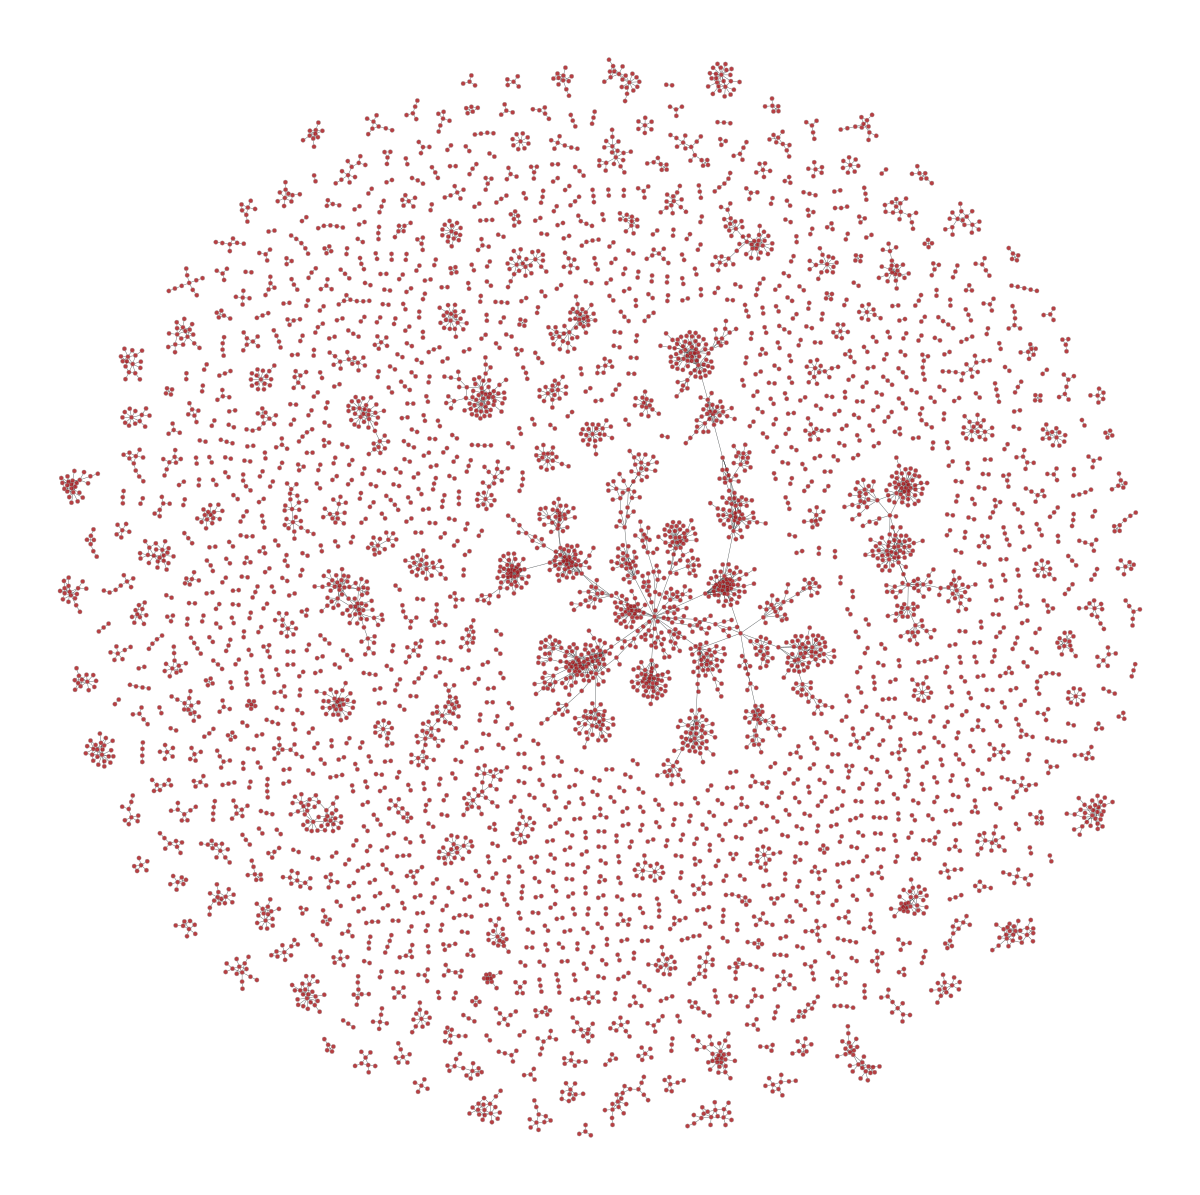

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f729888f430, at 0x7f729888ffa0>

In [6]:
graph_draw(G)

## Get buckets from graph
### Connect rhymes via overlapping rhyme pairs
If A and B rhyme, and B and C rhyme, A and C should also rhyme. 
Go through each rhyme pair and create rhyming buckets.

In [10]:
edges = pairs.copy()
vertices = list(vocab)

G = nx.Graph()
G.add_nodes_from(vertices)
G.add_edges_from(edges)

In [11]:
buckets = list(nx.connected_components(G))
len(buckets), len(pairs)

(1237, 7256)

In [12]:
sum(len(bucket) for bucket in buckets)/len(buckets)

5.084074373484236

## Check buckets

In [14]:
len(buckets)

1237

In [15]:
twos = sum(len(bucket)==2 for bucket in buckets)
twos

726

In [16]:
len(buckets) - twos

511

In [17]:
not_twos = [bucket for bucket in buckets if len(bucket)>2]
sum(len(bucket) for bucket in not_twos)/len(not_twos)

9.465753424657533

In [18]:
not_twos.sort(key= lambda x: len(x), reverse=True)
for i, bucket in enumerate(not_twos):
    print(len(bucket), "\t" , i)
    print(bucket)

1054 	 0
{'kildevell', 'Nang', 'motormann', 'ørkenbunn', 'runden', 'kledt', 'bred', 'gjerdestav', 'vinterland', 'Staupersund', 'ubønnhørlighet', 'frem', 'sårer', 'blomstergrunn', 'bade', 'dommer', 'snever', 'flyvebåt', 'perlerand', 'årer', 'best', 'sæd', 'låt', 'lårer', 'binne', 'naglebor', 'brem', 'grunnen', 'bibelsted', 'stråleveld', 'Bø', 'plett', 'dåd', 'vidunderbad', 'mann', 'moské', 'ødeland', 'stjerneskinn', 'skjendte', 'merkestang', 'toneveld', 'lærte', 'kølleslag', 'strå', 'snor', 'enno', 'får', 'to', 'pastell', 'underklang', 'bor', 'tinde', 'forstå', 'hård', 'han', 'uren', 'rot', 'kristenhet', 'hegg', 'Rolland', 'idag', 'alfesang', 'sed', 'itu', 'vell', 'vandringsmann', 'kjerringgrin', 'milelang', 'ære', 'hel', 'tonehav', 'hammerslag', 'luer', 'tyrann', 'tinderad', 'jorden', 'ihu', 'slog', 'hjertelag', 'produkt', 'vinterkveld', 'iland', 'arvegods', 'for', 'jag', 'frelsesarmé', 'rå', 'bølgehære', 'vest', 'spredt', 'juvel', 'mod', 'Jerusalem', 'kristenblod', 'jente', 'bot', 'br

In [19]:
good_buckets_i = [7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49]
good_buckets = [buckets[i] for i in good_buckets_i]
print(len(good_buckets))
under_15 = [bucket for bucket in not_twos if len(bucket)<15]
print(len(under_15))
good_buckets += under_15
print(f"Number of buckets with len>2 that are alright: {len(good_buckets)} out of {len(not_twos)}\naka {len(not_twos)-len(good_buckets)} are bad")

covered_vocab = sum([len(bucket) for bucket in good_buckets])+twos*2

print(f"""
With the good buckets + all the pairs, we cover 
{covered_vocab} words out of {len(vocab)} total
aka we miss {len(vocab)-covered_vocab} words in the "bad" buckets
""")

35
461
Number of buckets with len>2 that are alright: 496 out of 511
aka 15 are bad

With the good buckets + all the pairs, we cover 
5322 words out of 6289 total
aka we miss 967 words in the "bad" buckets



## HCS !! 
We want to try to cluster = separate the components/buckets on index 1 through 6

from https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py

In [20]:
def highly_connected(G, E):
    """Checks if the graph G is highly connected
    Highly connected means, that splitting the graph G into subgraphs needs more than 0.5*|V| edge deletions
    This definition can be found in Section 2 of the publication.
    :param G: Graph G
    :param E: Edges needed for splitting G
    :return: True if G is highly connected, otherwise False
    """

    return len(E) > len(G.nodes) / 2


def remove_edges(G, E):
    """Removes all edges E from G
    Iterates over all edges in E and removes them from G
    :param G: Graph to remove edges from
    :param E: One or multiple Edges
    :return: Graph with edges removed
    """

    for edge in E:
        G.remove_edge(*edge)
    return G


def HCS(G):
    """Basic HCS Algorithm
    cluster labels, removed edges are stored in global variables
    :param G: Input graph
    :return: Either the input Graph if it is highly connected, otherwise a Graph composed of
    Subgraphs that build clusters
    """

    E = nx.algorithms.connectivity.cuts.minimum_edge_cut(G)

    if not highly_connected(G, E):
        G = remove_edges(G, E)
        sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        if len(sub_graphs) == 2:
            H = HCS(sub_graphs[0])
            _H = HCS(sub_graphs[1])

            G = nx.compose(H, _H)

    return G



def labelled_HCS(G):
    """
    Runs basic HCS and returns Cluster Labels
    :param G: Input graph
    :return: List of cluster assignments for the single vertices
    """

    _G = HCS(G)

    sub_graphs = (G.subgraph(c).copy() for c in nx.connected_components(_G))


    labels = np.zeros(shape=(len(G)), dtype=np.uint16)

    for _class, _cluster in enumerate(sub_graphs, 1):
        c = list(_cluster.nodes)
        labels[c] = _class

    return labels

In [21]:
more_buckets = []

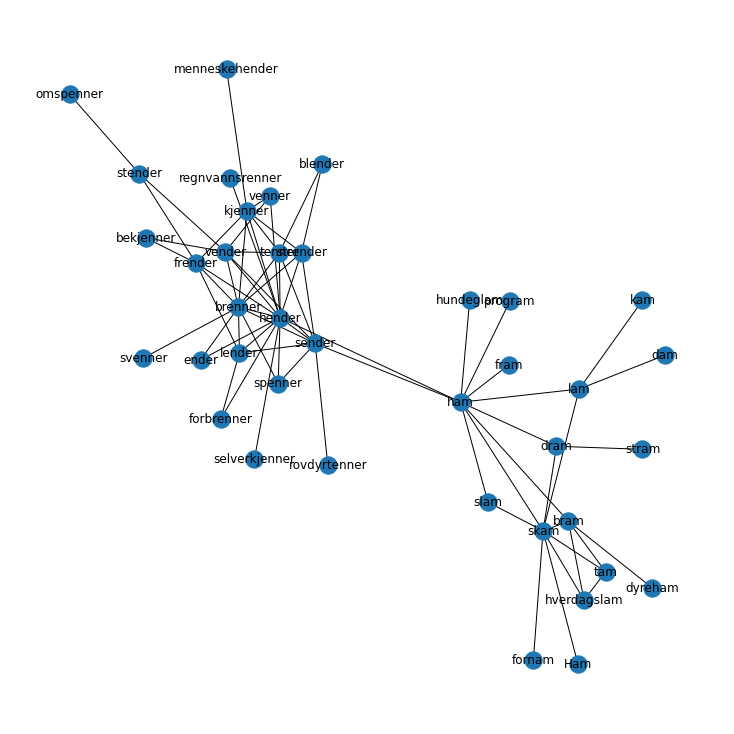

In [22]:
plt.rcParams["figure.figsize"] = (10,10)

smallest_big = not_twos[:7][-1]
edges = set()
for w1 in smallest_big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))

comp = nx.Graph()
comp.add_nodes_from(smallest_big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [23]:
x = HCS(comp)

Lost 28 from this graph


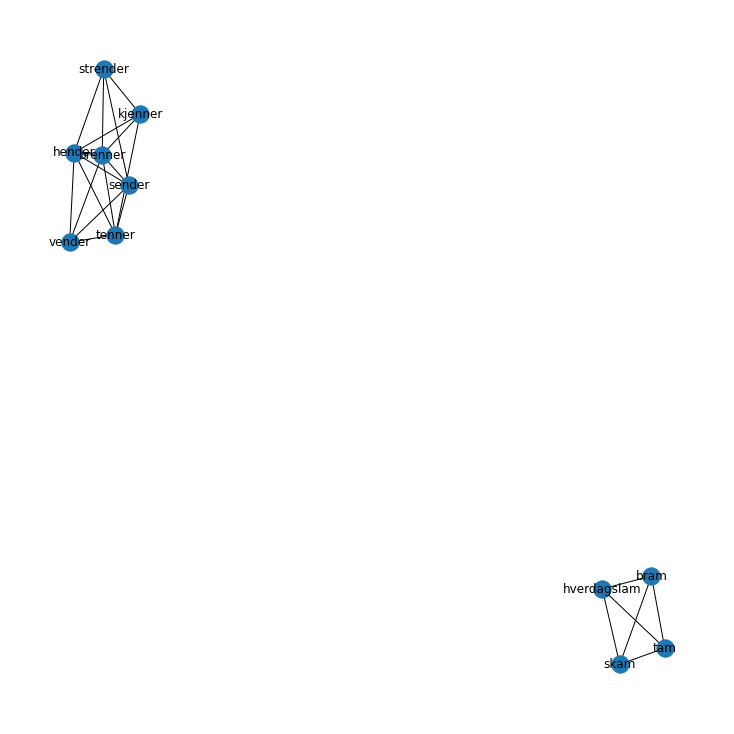

In [24]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

In [25]:
big = not_twos[:7][-2]
edges = set()
for w1 in big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))
comp = nx.Graph()
comp.add_nodes_from(big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [26]:
x = HCS(comp)

Lost 31 from this graph


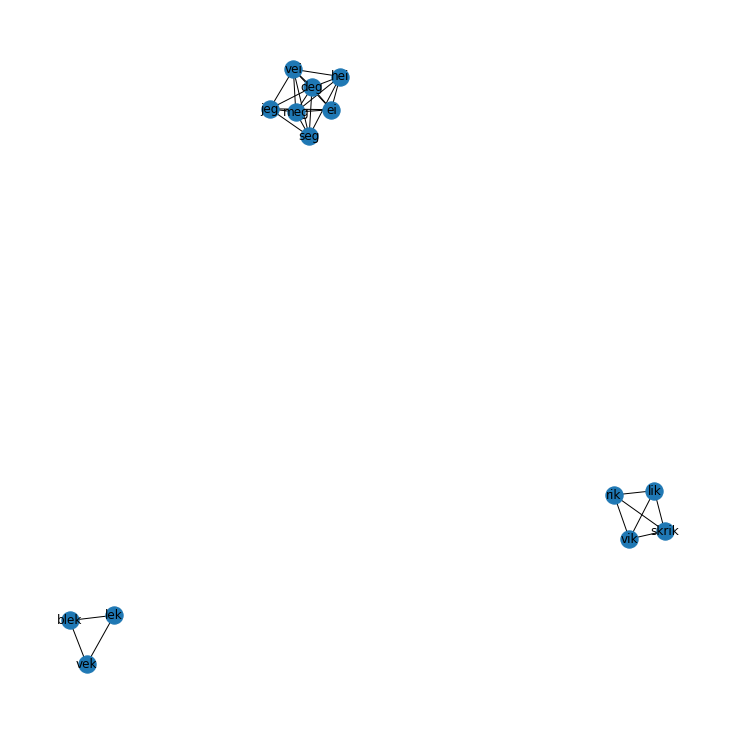

In [27]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

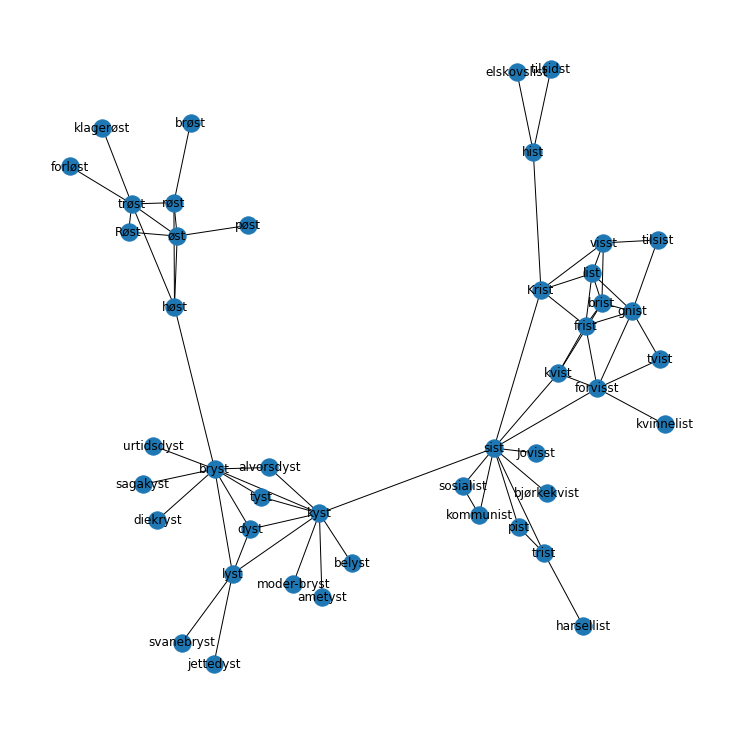

In [28]:
big = not_twos[:7][4]
edges = set()
for w1 in big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))
comp = nx.Graph()
comp.add_nodes_from(big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [29]:
x = HCS(comp)

Lost 33 from this graph


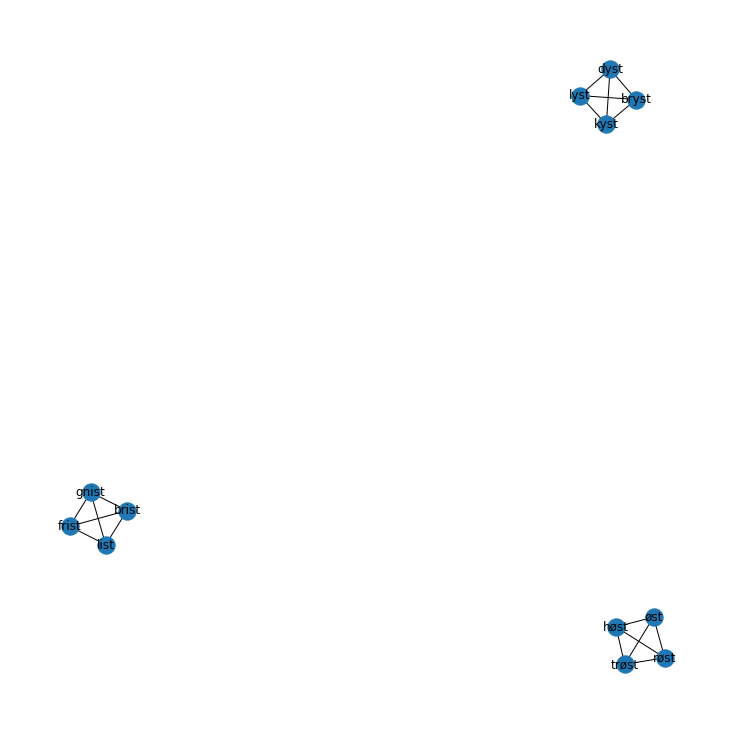

In [30]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

In [31]:
plt.rcParams["figure.figsize"] = (15,15)

smallest_big = not_twos[:7][3]
edges = set()
for w1 in smallest_big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))
comp = nx.Graph()
comp.add_nodes_from(smallest_big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [32]:
x = HCS(comp)

Lost 48 from this graph


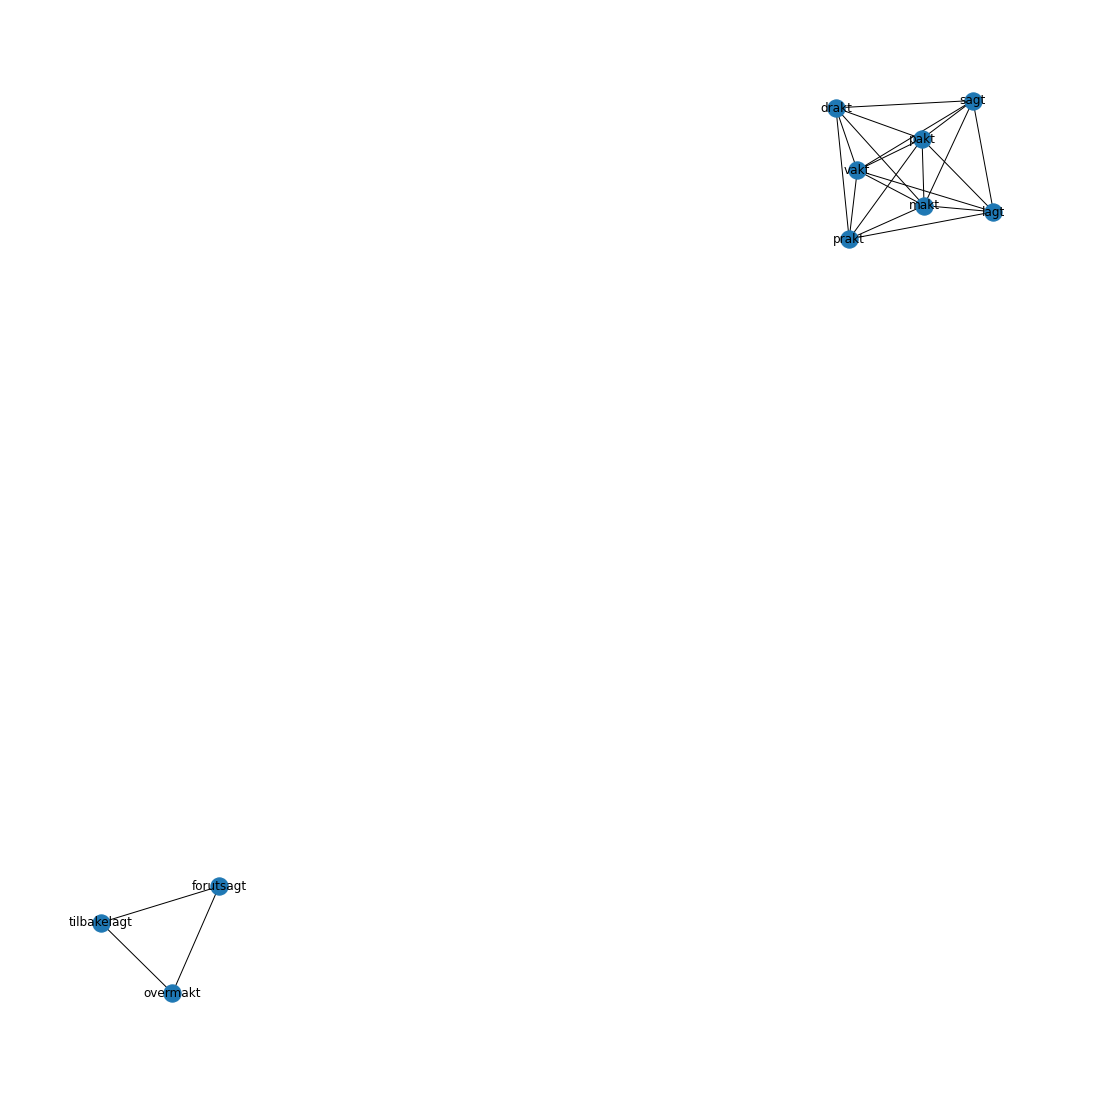

In [33]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

In [34]:
big = not_twos[:7][2]
edges = set()
for w1 in big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))
comp = nx.Graph()
comp.add_nodes_from(big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [35]:
x = HCS(comp)

Lost 48 from this graph


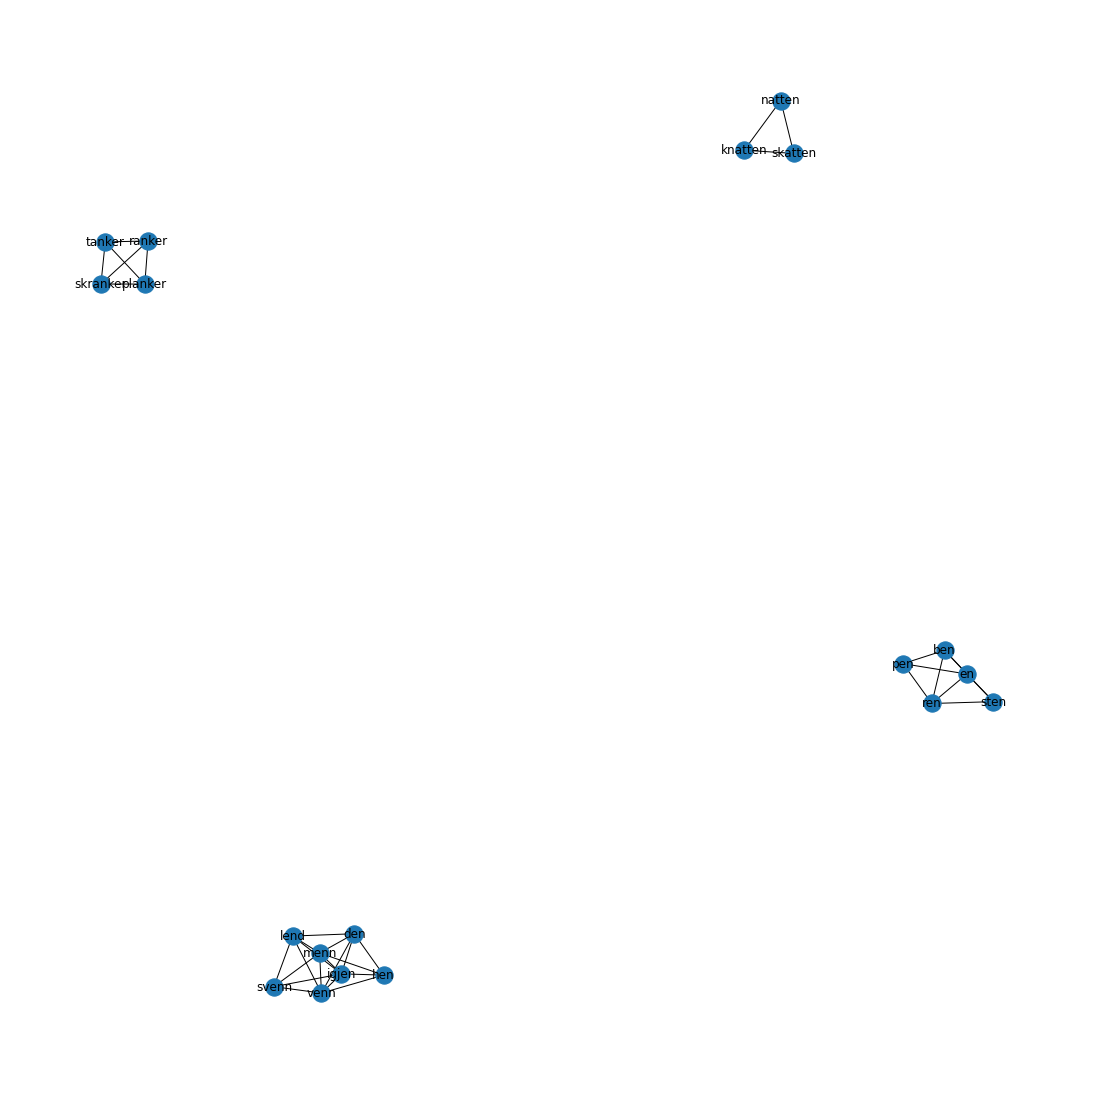

In [36]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

In [37]:
plt.rcParams["figure.figsize"] = (20,20)

big = not_twos[:7][1]
edges = set()
for w1 in big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))
comp = nx.Graph()
comp.add_nodes_from(big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [38]:
x = HCS(comp)

Lost 151 from this graph


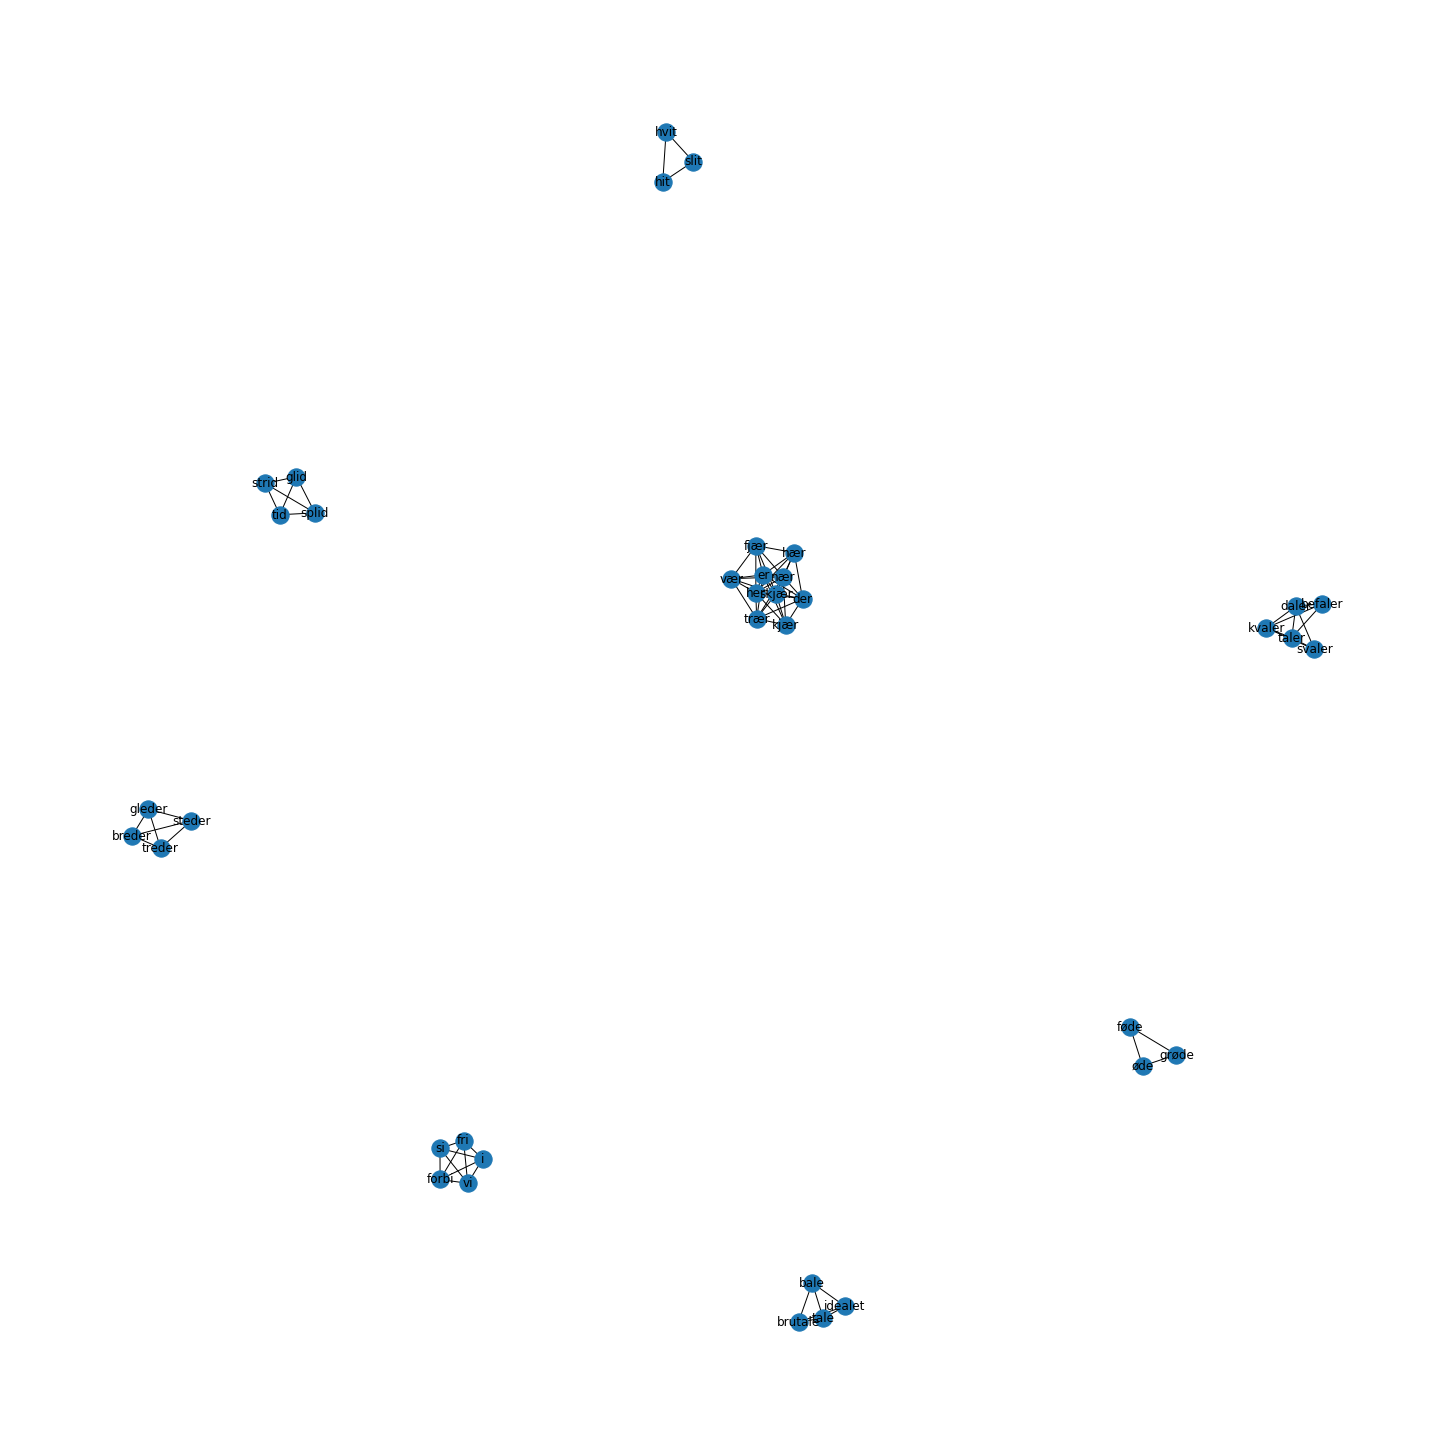

In [39]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

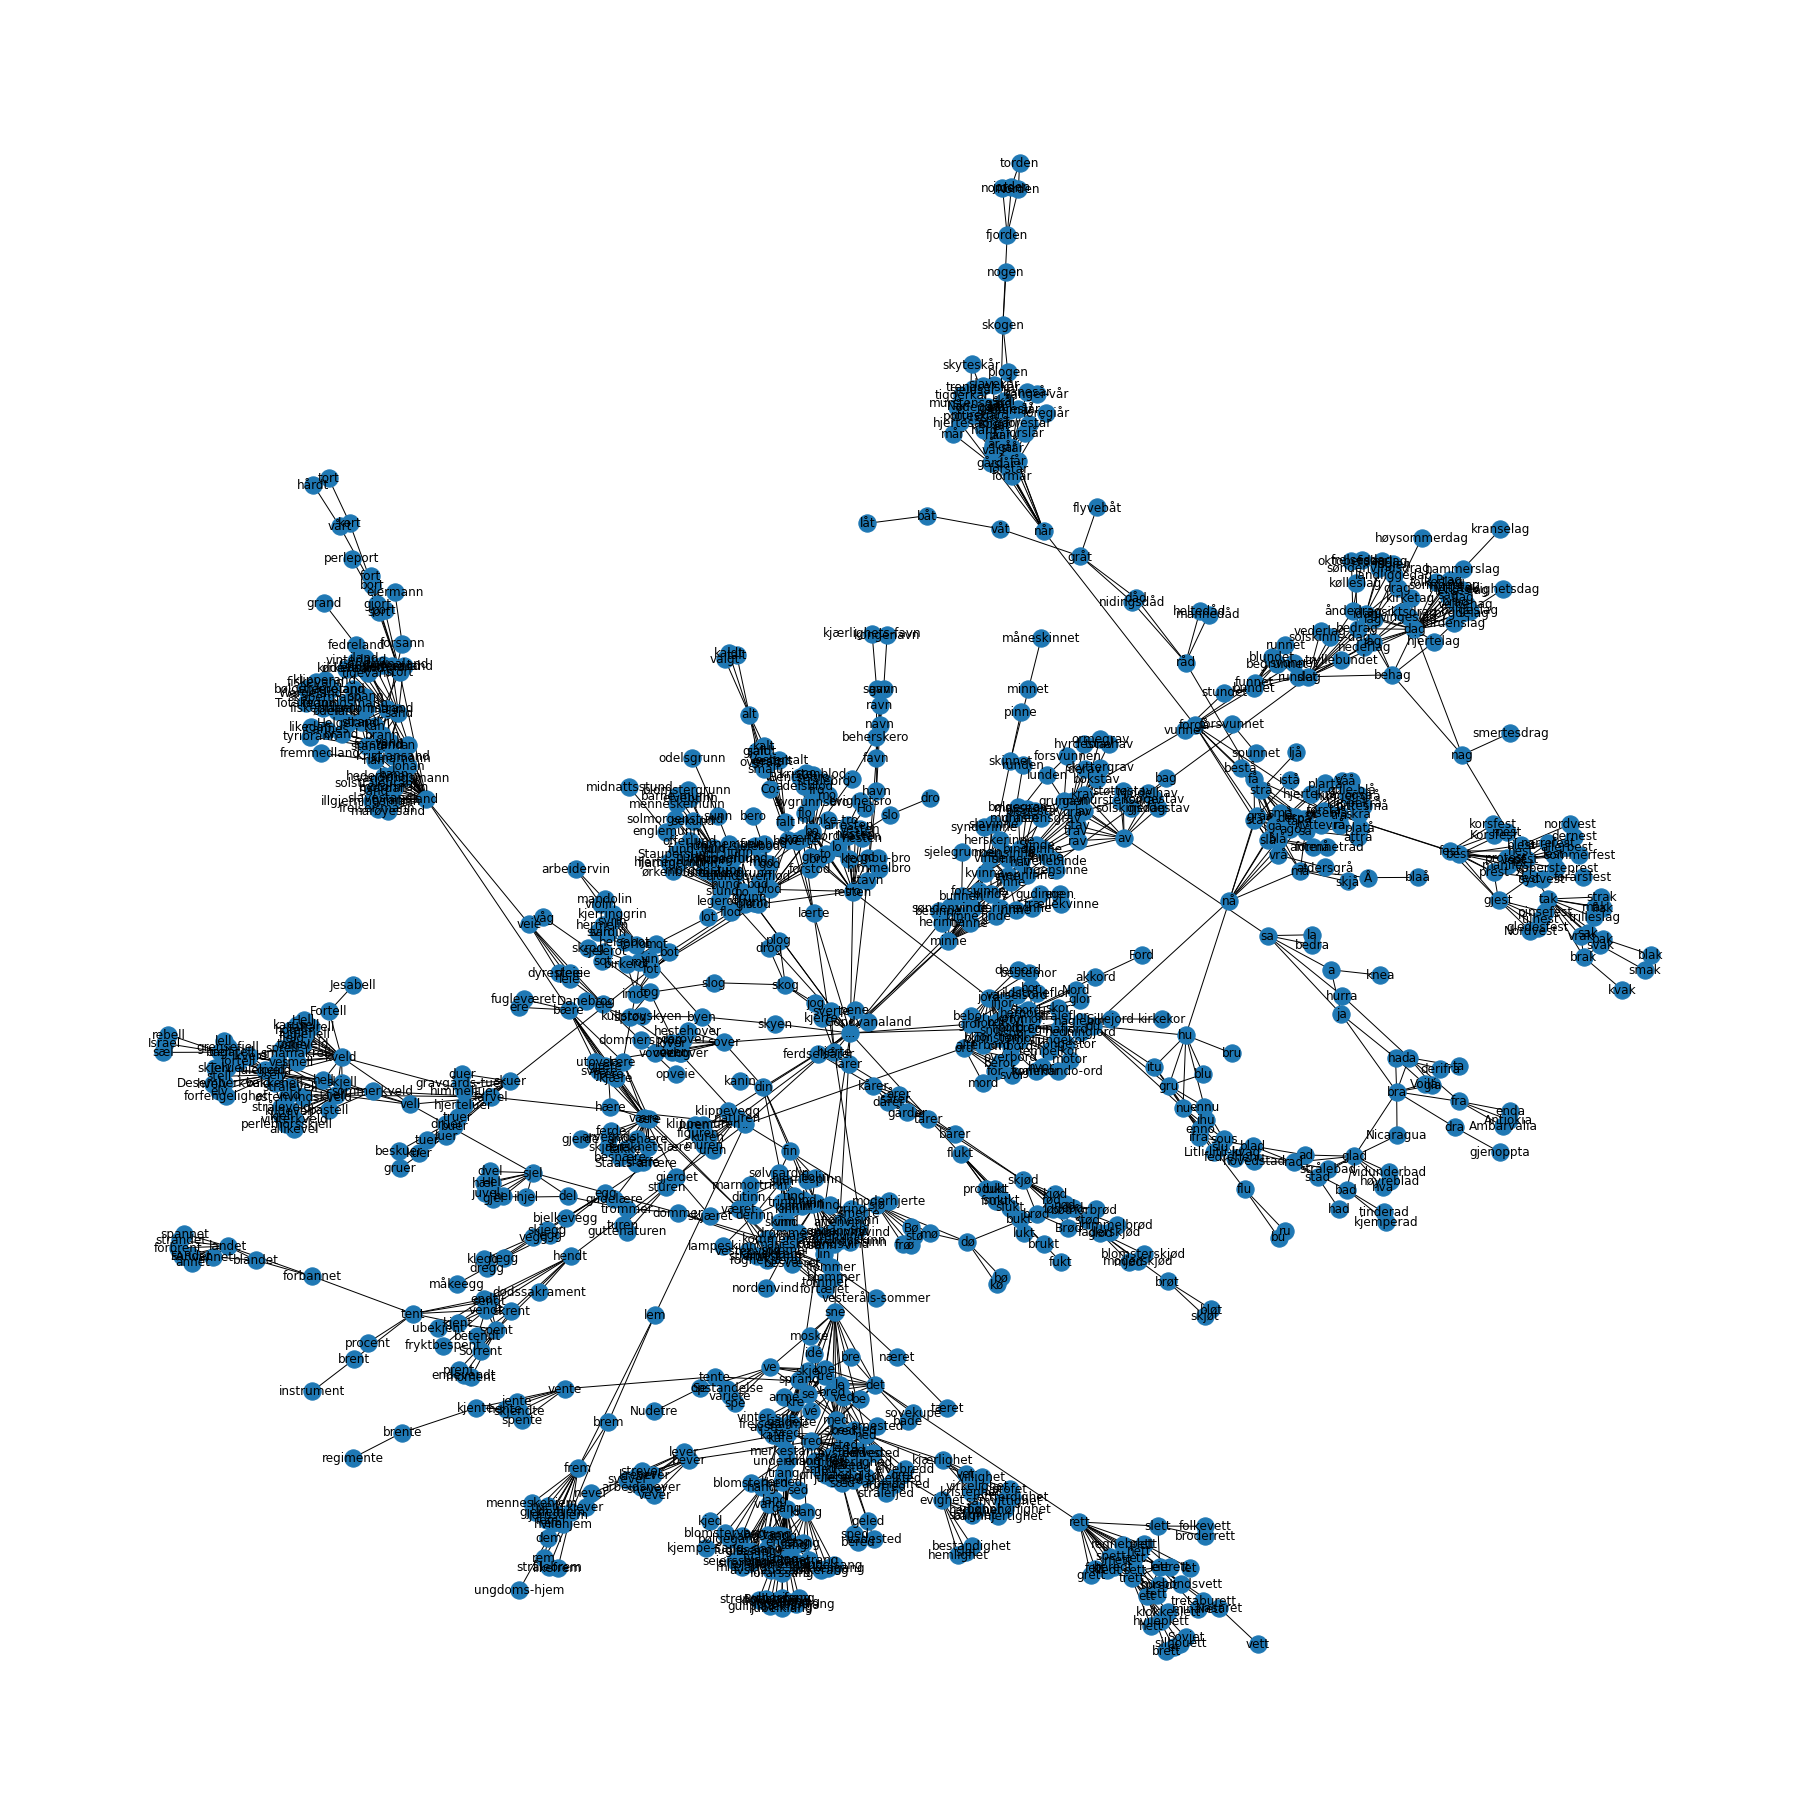

In [40]:
plt.rcParams["figure.figsize"] = (25,25)

big = not_twos[:7][0]
edges = set()
for w1 in big:
    for w2 in list(G.neighbors(w1)):
        edges.add((w1, w2))
comp = nx.Graph()
comp.add_nodes_from(big)
comp.add_edges_from(edges)
nx.draw(comp, with_labels=True)

In [41]:
x = HCS(comp)

Lost 803 from this graph


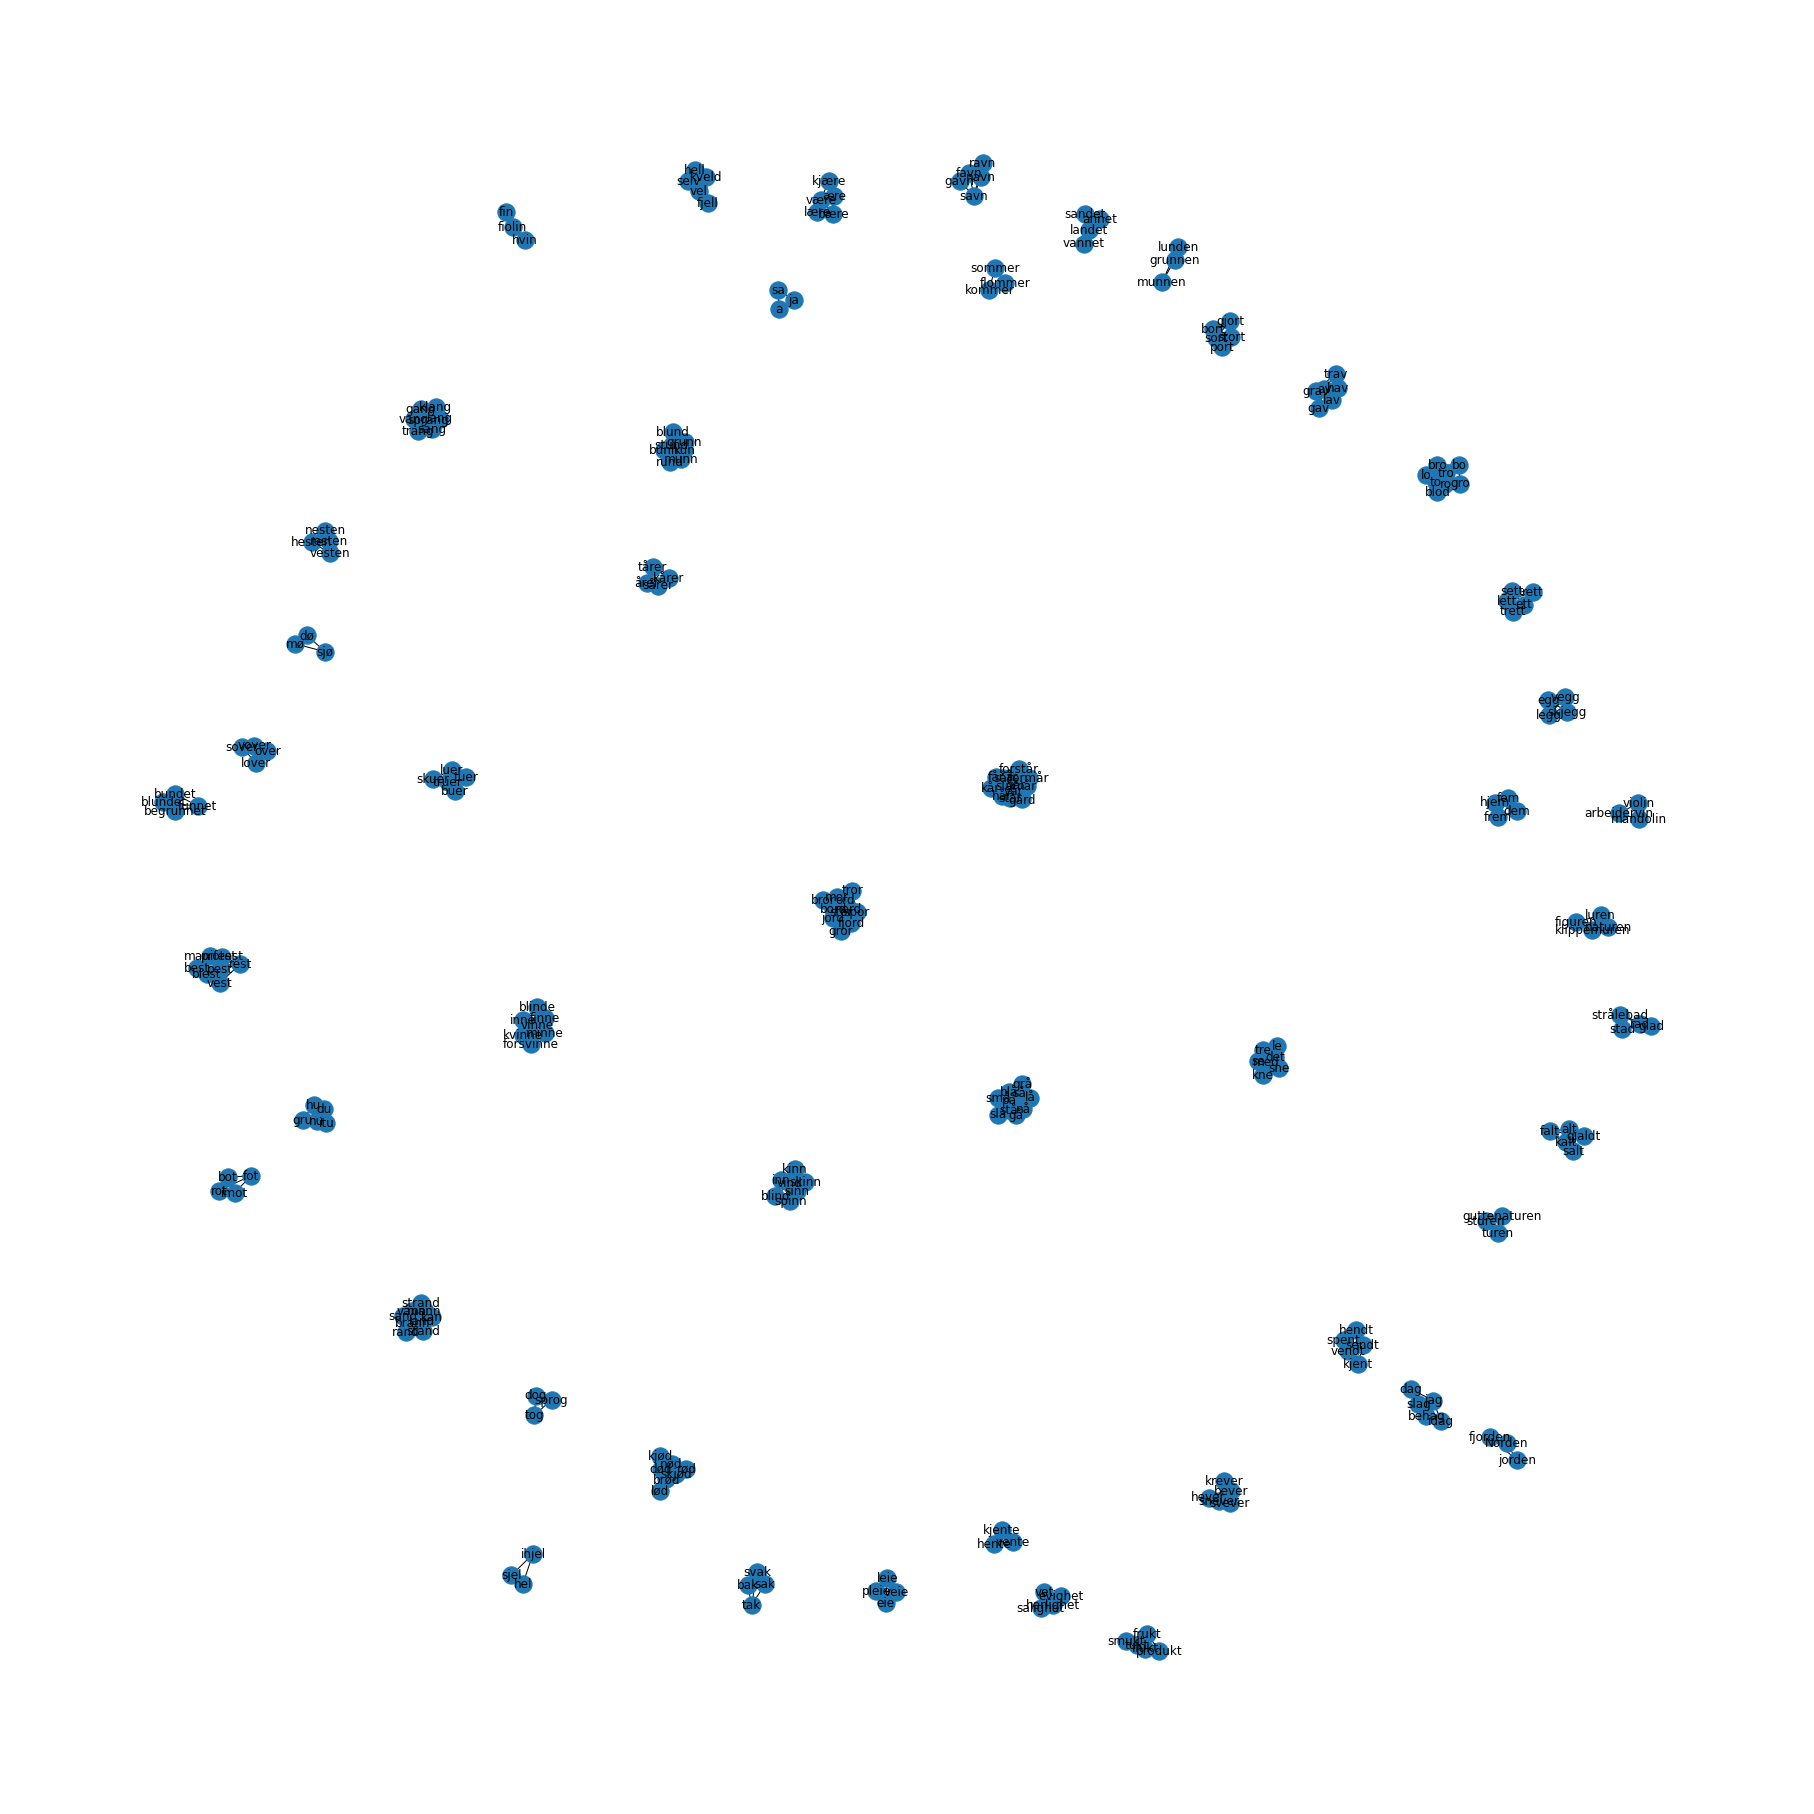

In [42]:
connected_comps = list(nx.connected_components(x))
words = [w for comp in connected_comps for w in comp if len(comp)==1]
print(f"Lost {len(words)} from this graph")
more_buckets += [comp for comp in connected_comps if len(comp)>1]  
nx.draw(nx.restricted_view(x, edges=[], nodes=(words)), with_labels=True)

In [43]:
print(len(more_buckets))
more_vocab = sum([len(bucket) for bucket in more_buckets])

print(f"""
With the buckets we got from graph clustering we got 
{more_vocab} words out of {len(vocab)} total
aka we miss {len(vocab)-covered_vocab-more_vocab} words in the "bad" buckets
""")

71

With the buckets we got from graph clustering we got 
355 words out of 6289 total
aka we miss 612 words in the "bad" buckets



In [44]:
good_buckets += more_buckets

## Create rhyme pairs from buckets

In [45]:
def get_mirrored_dupes(pairs):
    l = list(pairs)
    rem = set()

    for i,(a,b) in enumerate(l):
        if (b,a) in l[i:]:
            rem.add((b, a))
    return rem

In [48]:
graph_pairs = set()

for bucket in good_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        graph_pairs.update(c)
len(graph_pairs)

580701

In [49]:
pairs.update(graph_pairs)
len(pairs)

585268

In [51]:
words_a, words_b = zip(*pairs)

pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pairs)})
pair_df.to_csv("graph_produced_positive_pairs.tsv", sep="\t", index=False)